In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [198]:
from PIL import Image

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

## Data Prep
Downloading the data from Kaggle and processing it for the Model

In [5]:
# ! kaggle competitions download -c digit-recognizer -p$PATH

In [56]:
df = pd.read_csv("~/data/kaggle/mnist/train.csv")

In [57]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def test_train_split(df, split):
    idx = np.random.permutation(len(df))
    size = int(len(df)*split)
    train = df.iloc[idx[size:]]
    valid = df.iloc[idx[:size]]
    return train, valid

In [7]:
train_df, valid_df = test_train_split(df, 0.2)

In [173]:
class MnistDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.classes = df.label.value_counts()
        self.len = len(df)
        self.tensor_labels = torch.from_numpy(df.label.values).long()
        self.tensor_images = torch.from_numpy(df.drop(columns=['label']).values/255).float()
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.tensor_labels[idx], self.tensor_images[idx]

        

In [174]:
train_ds = MnistDataset(train_df)
valid_ds = MnistDataset(valid_df)

## Utils

In [196]:
def save_image(param):
    layer = param.detach()
    for i, feat in enumerate(layer):
        x = feat.numpy()
        flat_norm = (x -min(x))/(max(x)-min(x))
        img = flat_norm.reshape((28,28))
        im = Image.fromarray(np.uint8(img* 255), mode='L').resize((280,280))
        im.save(f'{i}.PNG')

## Explore Data

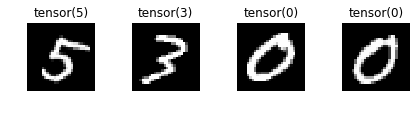

In [178]:
fig = plt.figure()
for i in range(4):
    label,image = train_ds[i]
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title(label)
    ax.axis('off')
    plt.imshow(image.numpy().reshape((28,28)), cmap='gray')
    

Text(0.5,1,'Train Classes Split')

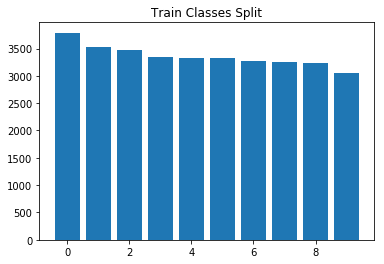

In [179]:
plt.bar([0,1,2,3,4,5,6,7,8,9],train_ds.classes)
plt.title("Train Classes Split")

Text(0.5,1,'Valid Classes Split')

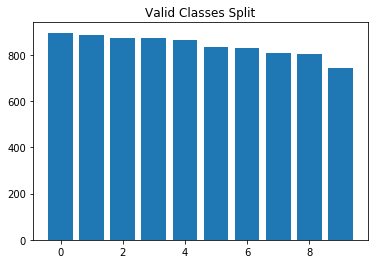

In [181]:
plt.bar([0,1,2,3,4,5,6,7,8,9], valid_ds.classes)
plt.title("Valid Classes Split")

## Metrics

In [186]:
def accuracy(preds,labels):
    preds_np = np.argmax(preds.detach().numpy(), axis=1)
    return np.sum(preds_np == labels.detach().numpy())/len(preds_np)
    

## Model Definition

In [207]:
# We'll just be inportating models from here
in_size = 784
out_size = 10

model = nn.Sequential(
    nn.Linear(in_size,392, bias=False),
    nn.Linear(392,out_size, bias=False))

## Train Defintion

In [208]:
lr = 1e-3 # Learning Rate
bs = 16 # Bacth Size

# Loss Definiton
cross_en = nn.CrossEntropyLoss()

# Optimiser
optim = torch.optim.SGD(model.parameters(),lr=lr)

# Dataloader
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

## Train Loop

In [209]:
def train_step(batch, train):
    labels, data = batch
    preds = model(data)
    loss = cross_en(preds, labels)
    acc = accuracy(preds,labels)
    if train:
        optim.zero_grad() # zero gradients (?? why do we do this)
        loss.backward() # calcuate gradients
        optim.step() # updated weights
    return loss.item(), acc
    

In [210]:
epochs = 200

In [211]:
train_loss_t = []
train_acc_t = []
valid_loss_t = []
valid_acc_t = []

In [212]:
for i in range(epochs):
    train_loss_ep = []
    train_acc_ep = []
    valid_loss_ep = []
    valid_acc_ep = []
    
    for train_batch, valid_batch in zip(train_dl, valid_dl):
        train_loss, train_acc = train_step(train_batch, True)
        valid_loss, valid_acc = train_step(valid_batch, False)
        train_loss_ep.append(train_loss)
        train_acc_ep.append(train_acc)
        valid_loss_ep.append(valid_loss)
        valid_acc_ep.append(valid_acc)
    if i% 20 == 0:
        print(f'epoch:{i} Train Loss:  {np.mean(train_loss_ep)}, Validation Loss {np.mean(valid_loss_ep)}')
    train_loss_t.append(np.mean(train_loss_ep))
    train_acc_t.append(np.mean(train_acc_ep))
    valid_loss_t.append(np.mean(valid_loss_ep))
    valid_acc_t.append(np.mean(valid_acc_ep))


epoch:0 Train Loss:  2.170699899764288, Validation Loss 2.1679271806989395
epoch:20 Train Loss:  0.49726212680339815, Validation Loss 0.5029429439419791
epoch:40 Train Loss:  0.3838306537412462, Validation Loss 0.3942934179589862
epoch:60 Train Loss:  0.35160346224194483, Validation Loss 0.3576369456166313
epoch:80 Train Loss:  0.32924174649374827, Validation Loss 0.34030436850729445
epoch:100 Train Loss:  0.3359508802777245, Validation Loss 0.32957852814878735
epoch:120 Train Loss:  0.31961486234551384, Validation Loss 0.32113251677581245
epoch:140 Train Loss:  0.2994199107374464, Validation Loss 0.3167805818716685
epoch:160 Train Loss:  0.29445329475970494, Validation Loss 0.3121364332948412
epoch:180 Train Loss:  0.30780934299741475, Validation Loss 0.30945140722252074


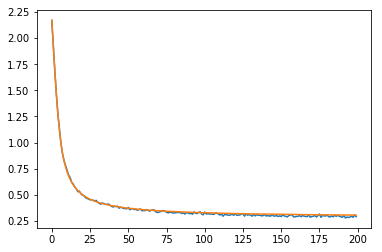

In [213]:
plt.plot(train_loss_t)
plt.plot(valid_loss_t)

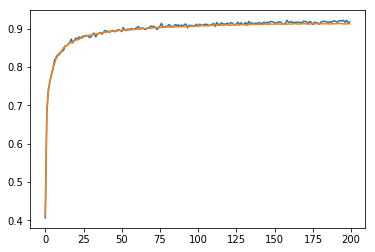

In [214]:
plt.plot(train_acc_t)
plt.plot(valid_acc_t)

In [215]:
valid_acc_t[-1]

0.9126190476190477

In [195]:
valid_acc_t[-1]

0.905

In [199]:
for m in model.parameters():
    save_image(m)

## Submission

In [268]:
df_test = pd.read_csv("~/data/kaggle/mnist/test.csv")


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [269]:
df_test.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
class MnistDatasetTest(Dataset):
    def __init__(self, df, is_test=False):
        self.len = len(df)
        self.tensor_images = torch.from_numpy((df.values)/255).float()
        
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.tensor_images[idx]

In [229]:
test_ds = MnistDatasetTest(df_test)

In [230]:
bs = 32
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

In [281]:
preds = []

for batch in test_dl:
    logits = model(batch)
    preds_np = np.argmax(logits.detach().numpy(), axis=1)
    preds.extend(preds_np)
    

In [282]:
data = {'ImageId': range(1, len(preds)+1) ,"Label": preds}
subm_df = pd.DataFrame(data=data)
subm_df.append(spam)
subm_df.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [283]:
subm_df.to_csv("subm1-linear_layer.csv", index=False)

In [284]:
! kaggle competitions submit  digit-recognizer -f subm1-linear_layer.csv -m "linear layer subm4" 

100%|████████████████████████████████████████| 208k/208k [00:11<00:00, 18.3kB/s]
Successfully submitted to Digit Recognizer